In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

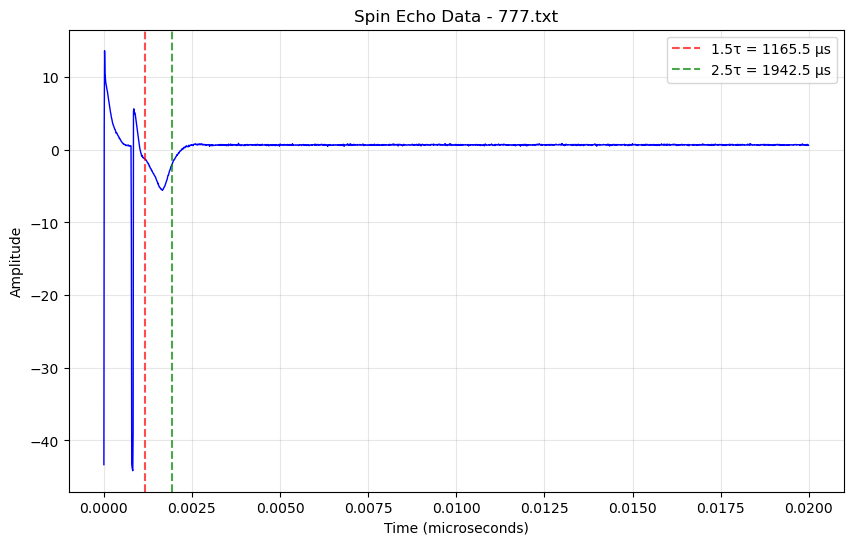

In [10]:
# Example: Plot data from a specific file
filename = '777.txt'  # Replace with your desired filename
foldername = 'spin_echo'  # Using the same folder as in the analysis

# Load and plot the data
filepath = os.path.join(foldername, filename)
data = np.loadtxt(filepath)

# Handle different data formats
if data.ndim == 2 and data.shape[1] == 2:
  time_array = data[:, 0]
  amplitude = data[:, 1]
else:
  # Estimate time array if not provided
  tau_str = filename.replace('.txt', '').split('_')[-1]
  tau = float(tau_str)
  estimated_duration = 10 * tau
  time_step = estimated_duration / len(data)
  time_array = np.arange(len(data)) * time_step
  amplitude = data

plt.figure(figsize=(10, 6))
plt.plot(time_array, amplitude, 'b-', linewidth=1)

# Extract tau value from filename and draw vertical lines at 1.5*tau and 2.5*tau
tau_str = filename.replace('.txt', '')
tau = float(tau_str)

plt.axvline(x=1.5*tau/1e6, color='r', linestyle='--', alpha=0.7, label=f'1.5τ = {1.5*tau:.1f} μs')
plt.axvline(x=2.5*tau/1e6, color='g', linestyle='--', alpha=0.7, label=f'2.5τ = {2.5*tau:.1f} μs')
plt.legend()
plt.xlabel('Time (microseconds)')
plt.ylabel('Amplitude')
plt.title(f'Spin Echo Data - {filename}')
plt.grid(True, alpha=0.3)
plt.show()

In [21]:
from scipy.optimize import curve_fit

def analyze_t2_decay(foldername):
  """
  Analyze T2 decay by finding max amplitude around 2*tau for each tau file
  
  Parameters:
  foldername: str - path to folder containing tau files
  """
  tau_values = []
  max_amplitudes = []
  
  # Get all .txt files in the folder
  txt_files = [f for f in os.listdir(foldername) if f.endswith('.txt')]
  
  for filename in txt_files:
    # Extract tau value from filename (assuming format like "tau_5.2.txt" for 5.2 microseconds)
    tau_str = filename.replace('.txt', '').split('_')[-1]
    tau = float(tau_str)
    
    # Load data from file
    filepath = os.path.join(foldername, filename)
    data = np.loadtxt(filepath)
    
    # Assuming data is time-series with uniform time steps
    # Calculate time array (you may need to adjust based on your actual time step)
    # Determine time step by analyzing the data structure
    if data.ndim == 2 and data.shape[1] == 2:
      # If data has 2 columns, assume first column is time
      time_array = data[:, 0]
      data = data[:, 1]  # Use second column as amplitude data
    else:
      # If single column, estimate time step from typical sampling rates
      # or use a default based on common experimental setups
      estimated_duration = 10 * tau  # Assume measurement duration is ~10 times tau
      time_step = estimated_duration / len(data)
      time_array = np.arange(len(data)) * time_step
    
    # Define search range around 2*tau (from 1.5*tau to 2.5*tau)
    search_start = 1.5 * tau/1e6
    search_end = 2.5 * tau/1e6
    
    # Find indices within the search range
    search_mask = (time_array >= search_start) & (time_array <= search_end)
    
    if np.any(search_mask):
      # Find maximum amplitude in the search range
      search_data = data[search_mask]
      max_amp = np.max(np.abs(search_data))
    else:
      # If no data in range, use global max as fallback
      max_amp = np.max(np.abs(data))
    
    tau_values.append(tau)
    max_amplitudes.append(max_amp)
  
  # Sort by tau values
  sorted_indices = np.argsort(tau_values)
  tau_values = np.array(tau_values)[sorted_indices]
  max_amplitudes = np.array(max_amplitudes)[sorted_indices]
  
  # Plot max amplitude vs 2*tau
  plt.figure(figsize=(10, 6))
  plt.plot(2 * tau_values, max_amplitudes, 'bo-', markersize=8)
  plt.xlabel('2τ (microseconds)')
  plt.ylabel('Maximum Amplitude')
  plt.title('T2 Decay: Max Amplitude vs 2τ')
  plt.grid(True, alpha=0.3)
  plt.show()
  
  return tau_values, max_amplitudes

def fit_t2_decay(tau_values, max_amplitudes):
  """
  Fit exponential decay to find T2 relaxation time
  
  Parameters:
  tau_values: array - tau values in microseconds
  max_amplitudes: array - corresponding maximum amplitudes
  
  Returns:
  T2: float - T2 relaxation time in microseconds
  """
  
  # Define exponential decay function: A * exp(-2*tau/T2)
  def exp_decay(tau, A, T2):
    return A * np.exp(-2 * tau / T2)
  
  # Convert tau values to seconds for fitting
  tau_values_sec = tau_values / 1e6
  
  # Fit the curve
  try:
    popt, pcov = curve_fit(exp_decay, tau_values_sec, max_amplitudes, 
                p0=[max_amplitudes[0], np.mean(tau_values_sec)])
    A_fit, T2_fit = popt
    
    # Plot original data and fit
    plt.figure(figsize=(10, 6))
    plt.plot(2 * tau_values_sec, max_amplitudes, 'bo', markersize=8, label='Data')
    
    # Generate smooth curve for fit
    tau_smooth_sec = np.linspace(tau_values_sec[0], tau_values_sec[-1], 100)
    fit_smooth = exp_decay(tau_smooth_sec, A_fit, T2_fit)
    plt.plot(2 * tau_smooth_sec, fit_smooth, 'r-', linewidth=2, 
      label=f'Fit: T2 = {T2_fit:.6f} s')
    
    plt.xlabel('2τ (seconds)')
    plt.ylabel('Maximum Amplitude')
    plt.title('T2 Decay Fit')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"Fitted T2 relaxation time: {T2_fit*1e6:.2f} microseconds")
    print(f"Fitted amplitude: {A_fit:.2f}")
    
    return T2_fit * 1e6  # Return T2 in microseconds
    
  except Exception as e:
    print(f"Fitting failed: {e}")
    return None

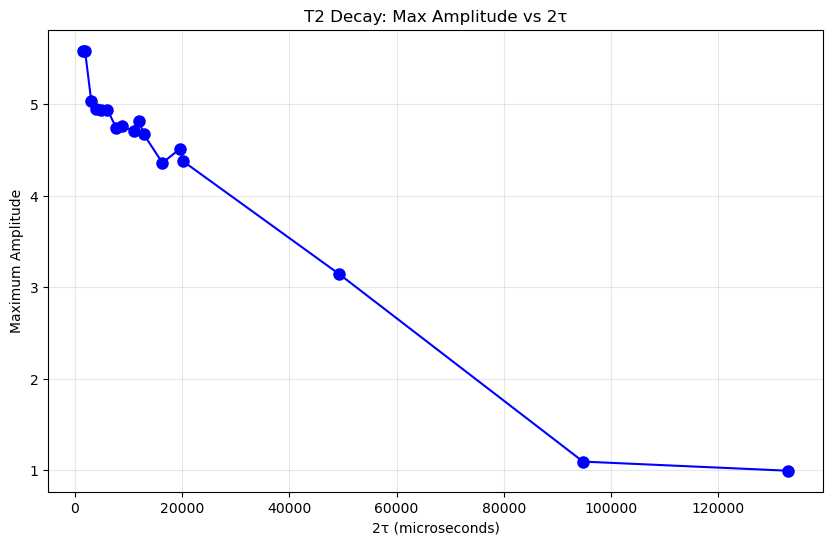

In [22]:
tauvalues, maxamplitude = analyze_t2_decay('spin_echo')

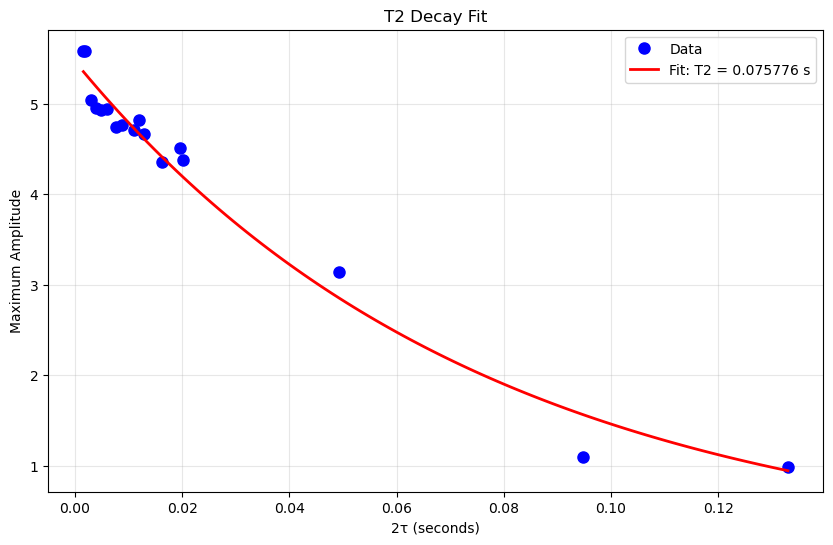

Fitted T2 relaxation time: 75776.36 microseconds
Fitted amplitude: 5.46


75776.35583412161

In [23]:
fit_t2_decay(tauvalues, maxamplitude)